In [1]:
import phasic
import numpy as np
import matplotlib.pyplot as plt
from phasic import Graph
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (8, 5.5)
plt.rcParams['font.size'] = 11

# Python version of add_epoch

In [2]:
def epoch_coalescent(n, size, graph=None, edge_trans=None, epoch=0):
    """
    Build coalescent graph with multiple time epochs.
    
    Args:
        n: Number of lineages
        size: Population size for this epoch
        graph: Existing graph to extend (None for first epoch)
        edge_trans: Transition rates from previous epoch
        epoch: Epoch label
    
    Returns:
        Graph with epoch added
    """
    state_vector_length = n + 1

    if graph is None:
        # Create initial graph for first epoch
        graph = phasic.Graph(state_vector_length)
        starting_vertex = graph.starting_vertex()
        initial_state = np.zeros(n + 1, dtype=int)
        initial_state[0] = n
        initial_state[-1] = epoch
        
        vertex = graph.find_or_create_vertex(initial_state)
        starting_vertex.add_edge(vertex, 1)
        index = 1
    else:
        # Add transitions from previous epoch
        nr_states = graph.vertices_length()
        for i in range(1, nr_states):
            if edge_trans is None or np.isnan(edge_trans[i - 2]):
                continue
            
            vertex = graph.vertex_at(i)
            state = vertex.state()
            sister_state = state.copy()
            sister_state[-1] = epoch
            
            child = graph.find_or_create_vertex(sister_state)
            vertex.add_edge(child, [edge_trans[i - 2]])
        index = nr_states + 1

    # Build coalescent transitions within this epoch
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)

        # Loop over all classes of lineages
        for i in range(n):
            for j in range(i, n):
                state = vertex.state()

                # If same class, need at least two to coalesce
                if i == j:
                    if state[i] < 2:
                        continue
                    # Coalescence rate
                    rate = state[i] * (state[i] - 1) / 2
                else:
                    # Need at least one in each class
                    if state[i] < 1 or state[j] < 1:
                        continue
                    # Number of combinations
                    rate = state[i] * state[j]

                rate = rate / size

                # Create child state
                child_state = state.copy()
                child_state[i] -= 1
                child_state[j] -= 1
                child_state[i + j + 1] += 1

                child = graph.find_or_create_vertex(child_state)
                vertex.add_edge(child, [rate])

        index += 1

    if epoch == 0:
        return graph
    return graph


def add_epoch(n, size, graph, epoch_trans, epoch):
    """Wrapper function to add an epoch to existing graph."""
    return epoch_coalescent(n, size, graph, epoch_trans, epoch)

## Check that I get the same as Janek for n=10

In [3]:
janek = np.array([8.807791589074768, 177.8449395799212, 5388.12207361224, 
                   216313.46645481227, 10829024.877199283])

In [4]:
epochs = [0, 1, 2]
pop_sizes = [1, 5, 10]
n_samples = 10

In [5]:
graph = epoch_coalescent(n_samples, pop_sizes[0])

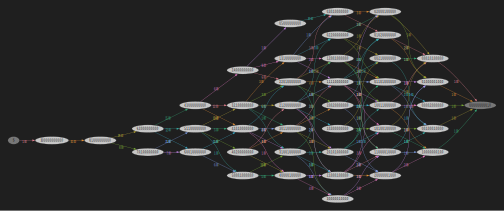

In [6]:

graph.plot()


In [7]:

graph.moments(5)

[1.7999999999999994,
 4.398141849332324,
 14.172263794406646,
 58.136567268791524,
 293.2290904044229]

In [8]:
stop_probs = np.array(graph.stop_probability(epochs[1])[1:-1])
accum_v_time = np.array(graph.accumulated_visiting_time(epochs[1])[1:-1])
epoch_trans_rates = stop_probs / accum_v_time
add_epoch(n_samples, pop_sizes[1], graph, epoch_trans_rates, 2)
graph.moments(5)

[4.895293078157219,
 48.28515673985444,
 725.857747216261,
 14558.473030729241,
 364441.2077035921]

In [9]:
stop_probs = np.array(graph.stop_probability(epochs[2])[1:-1])
accum_v_time = np.array(graph.accumulated_visiting_time(epochs[2])[1:-1])
epoch_trans_rates = stop_probs / accum_v_time
add_epoch(n_samples, pop_sizes[2], graph, epoch_trans_rates, 3)
graph.moments(5)

[8.393245330304106,
 156.95481610831527,
 4662.546111150168,
 186495.79462589262,
 9329755.386529114]

In [10]:
mine = graph.moments(5)
mine

[8.393245330304106,
 156.95481610831527,
 4662.546111150168,
 186495.79462589262,
 9329755.386529114]

In [11]:
janek

array([8.80779159e+00, 1.77844940e+02, 5.38812207e+03, 2.16313466e+05,
       1.08290249e+07])

In [12]:
(mine - janek) / janek

array([-0.04706586, -0.11746257, -0.13466212, -0.13784473, -0.13844917])

Note: Graph visualization is not available in Python version. Use R version or export graph structure for visualization.

In [13]:
graph.moments(5)

[8.393245330304106,
 156.95481610831527,
 4662.546111150168,
 186495.79462589262,
 9329755.386529114]

### SFS

In [14]:
# Get states and remove epoch label column
state_mat = graph.states()
rewards = state_mat[:, :-1]  # Remove last column (epoch labels)

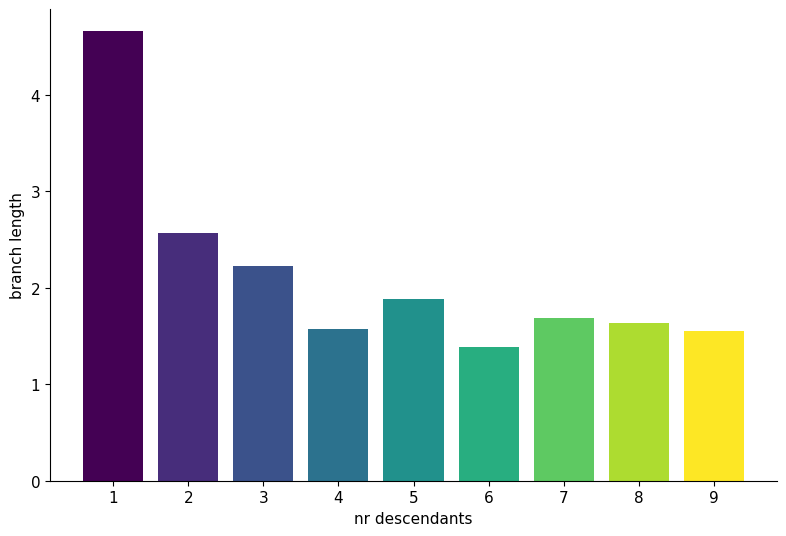

In [15]:
# Compute site frequency spectrum
sfs = np.zeros(n_samples - 1)
for i in range(n_samples - 1):
    reward_vec = rewards[:, i]
    transformed_graph = graph.reward_transform(reward_vec)
    sfs[i] = transformed_graph.moments(1)[0]

# Plot SFS
fig, ax = plt.subplots(figsize=(8, 5.5))
x = np.arange(1, len(sfs) + 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(sfs)))
ax.bar(x, sfs, color=colors, width=0.8)
ax.set_xlabel('nr descendants')
ax.set_ylabel('branch length')
ax.set_xticks(x)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### SFS using distribution context

In [16]:
# Create fresh graph for distribution context approach
distr_cont_graph = epoch_coalescent(n_samples, pop_sizes[0])
state_mat = distr_cont_graph.states()
rewards = state_mat[:, :-1]

tmrca_pdf = []
time_points = []

# Create distribution context
ctx = distr_cont_graph.distribution_context()
prev_size = 0

while ctx.cdf() < 0.999:
    tmrca_pdf.append(ctx.pdf())
    time_points.append(ctx.time())
    
    # Update weights based on current epoch
    current_time = ctx.time()
    size = pop_sizes[np.searchsorted(epochs, current_time, side='right') - 1]
    
    if size != prev_size:
        distr_cont_graph.update_weights(np.array([1.0 / size]))
    prev_size = size
    
    ctx.step()

expected_visits = ctx.accumulated_visiting_time()

# Compute SFS from expected visits
sfs = []
for i in range(rewards.shape[1]):
    sfs.append(np.sum(expected_visits * rewards[:, i]))

# Plot SFS
fig, ax = plt.subplots(figsize=(8, 5.5))
x = np.arange(1, len(sfs) + 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(sfs)))
ax.bar(x, sfs, color=colors, width=0.8)
ax.set_xlabel('nr descendants')
ax.set_ylabel('branch length')
ax.set_xticks(x)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

INFO: loaded elimination trace from cache (1cf242292561c0fd3f59fce4a5a6e703405be75ffe07e9f22a6ceed002d38423)


AttributeError: 'phasic.phasic_pybind.ProbabilityDistributionContext' object has no attribute 'accumulated_visiting_time'

In [ ]:
# Compare PDF from distribution context with time-inhomogeneous approach
x = np.linspace(0, max(time_points), 1000)
pdf_values = graph.dph(x)

fig, ax = plt.subplots(figsize=(8, 5.5))
ax.plot(time_points, tmrca_pdf, label='dist_context', linewidth=2, color=plt.cm.viridis(0.2))
ax.plot(x, pdf_values, label='time_inhom', linewidth=2, color=plt.cm.viridis(0.8))
ax.set_xlabel('time')
ax.set_ylabel('probability density')
ax.set_xlim(0, 20)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

AttributeError: 'Graph' object has no attribute 'dph'

## Sample size n_samples = 2

In [17]:
epochs = [0, 1, 2]
pop_sizes = [1, 5, 10]
n_samples = 2

### epoch 1

In [18]:
graph = epoch_coalescent(n_samples, pop_sizes[0])
print("Moments after epoch 1:")
graph.moments(5)

Moments after epoch 1:


[1.0, 2.0, 6.0, 24.0, 120.0]

### epoch 2

In [19]:
stop_probs = np.array(graph.stop_probability(epochs[1])[1:-1])
accum_v_time = np.array(graph.accumulated_visiting_time(epochs[1])[1:-1])
epoch_trans_rates = stop_probs / accum_v_time
add_epoch(n_samples, pop_sizes[1], graph, epoch_trans_rates, 2)
print("Moments after epoch 2:")
graph.moments(5)

Moments after epoch 2:


[1.7205868662796888,
 5.92083832882832,
 30.561949997842166,
 210.33795909673518,
 1809.5236495095849]

### epoch 3

In [20]:
stop_probs = np.array(graph.stop_probability(epochs[2])[1:-1])
accum_v_time = np.array(graph.accumulated_visiting_time(epochs[2])[1:-1])
epoch_trans_rates = stop_probs / accum_v_time
add_epoch(n_samples, pop_sizes[2], graph, epoch_trans_rates, 3)
print("Moments after epoch 3:")
graph.moments(5)

Moments after epoch 3:


[6.064335023183706,
 103.21094152249498,
 3007.6764528409444,
 119800.07305189,
 5986776.460027048]

# C++ version of add_epoch

Note: The C++ implementation details from the R notebook are part of the underlying phasic library and are accessible through the Python Graph API shown above.

**TODO:**

**For now I assume there is an empty slot at the end of the state vector that can be used to label epoch. It would be better if add_epoch somehow added a state slot at the end to the state vector and then put a 1 in that. That way the state vector would grow by one for each added epoch and those extra slots would have 0 or 1 in them.**

In [21]:
def standard_coalescent(n):
    """
    Build standard coalescent graph without epochs.
    
    Args:
        n: Number of lineages
    
    Returns:
        Graph representing standard coalescent
    """
    state_vector_length = n + 1
    graph = phasic.Graph(state_vector_length)
    starting_vertex = graph.starting_vertex()
    initial_state = np.zeros(n + 1, dtype=int)
    initial_state[0] = n
    initial_state[-1] = 0  # Epoch 0
    
    vertex = graph.find_or_create_vertex(initial_state)
    starting_vertex.add_edge(vertex, 1)
    index = 1
    
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)
        
        # Loop over all classes of lineages
        for i in range(n):
            for j in range(i, n):
                state = vertex.state()
                
                # If same class, need at least two to coalesce
                if i == j:
                    if state[i] < 2:
                        continue
                    # Coalescence rate
                    rate = state[i] * (state[i] - 1) / 2
                else:
                    # Need at least one in each class
                    if state[i] < 1 or state[j] < 1:
                        continue
                    # Number of combinations
                    rate = state[i] * state[j]
                
                # Create child state
                child_state = state.copy()
                child_state[i] -= 1
                child_state[j] -= 1
                child_state[i + j + 1] += 1
                
                child = graph.find_or_create_vertex(child_state)
                vertex.add_edge(child, [rate])
        
        index += 1
    
    return graph

## Testing add_epochs_to_graph function

In [22]:
def add_epochs_to_graph(graph, epoch_params, times):
    """
    Add multiple epochs to a graph.
    
    Args:
        graph: Initial graph
        epoch_params: Array of population sizes for each epoch
        times: Array of times when epochs begin
    
    Returns:
        Graph with all epochs added
    """
    # Get number of samples from first state
    first_state = graph.vertex_at(2).state()
    n_samples = int(np.sum(first_state[:-1]))
    
    for i, params in enumerate(epoch_params):
        stop_probs = np.array(graph.stop_probability(times[i])[1:-1])
        accum_v_time = np.array(graph.accumulated_visiting_time(times[i])[1:-1])
        epoch_trans_rates = stop_probs / accum_v_time
        add_epoch(n_samples, params, graph, epoch_trans_rates, times[i] + 1)
    
    return graph


# Test with n=10 samples
epoch_params = np.array([1/5, 1/10])
times = np.array([1, 2])

graph = standard_coalescent(10)
graph = add_epochs_to_graph(graph, epoch_params, times)

print("Final moments:")
graph.moments(5)

Final moments:


[6.894314567466245,
 86.90626529613961,
 1638.788769292209,
 41272.50378595786,
 1300355.6286703139]

## Implementation notes

This shows the reason why special handling is needed when adding multiple epochs to ensure proper graph structure.

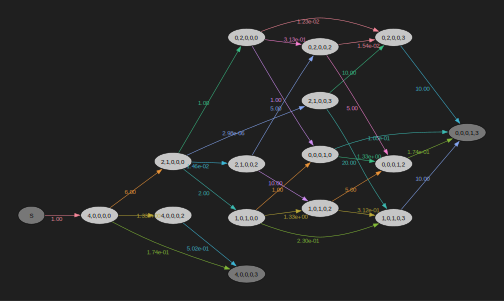

In [24]:
# Test with 4 samples
graph = standard_coalescent(4)
stop_probs = np.array(graph.stop_probability(1)[1:-1])
accum_v_time = np.array(graph.accumulated_visiting_time(1)[1:-1])
epoch_trans_rates = stop_probs / accum_v_time
add_epoch(4, 1/5, graph, epoch_trans_rates, 2)

stop_probs = np.array(graph.stop_probability(2)[1:-1])
accum_v_time = np.array(graph.accumulated_visiting_time(2)[1:-1])
epoch_trans_rates = stop_probs / accum_v_time
add_epoch(4, 1/10, graph, epoch_trans_rates, 3)

graph.plot()

In [25]:
# Moments should now work correctly
graph.moments(5)

[5.556123011173797,
 61.91242579453456,
 1053.2021491580638,
 24093.442974674163,
 691278.8452240147]